# 2 Exploratory Data Analysis<a id='2_Data_wrangling'></a>

In [1]:
# imports for handling lists
import itertools
# handling warnings
import warnings
# skimage imports
from skimage import data, color, filters, morphology, graph, measure, exposure
from skimage.filters import threshold_otsu, threshold_local, try_all_threshold, sobel, gaussian
from skimage.transform import rotate, rescale, resize
from skimage.feature import canny
from skimage.io import imsave
from skimage.util import img_as_ubyte
# scipy for image
from scipy import ndimage as ndi
# import for file interaction
import os
import io
# imports for reading from zip files
import zipfile
from PIL import Image
# array and data frame imports
import numpy as np
import pandas as pd
# helper functions
import helpers as h
# visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Exploring the tabular data

In [2]:
dir_path = r'C:\SPRINGBOARD\retinopathy-detection'
retina_data = pd.read_csv(r'{}\data_processed\labels_sizes.csv'.format(dir_path))
retina_data.rename(columns = {'Retinopathy grade': 'label'}, inplace=True)
retina_data.head()

Image name    Zip File       Image Size  label  \
0  20051019_38557_0100_PP.tif  Base11.zip  (1488, 2240, 3)      3   
1  20051020_43808_0100_PP.tif  Base11.zip  (1488, 2240, 3)      0   
2  20051020_43832_0100_PP.tif  Base11.zip  (1488, 2240, 3)      1   
3  20051020_43882_0100_PP.tif  Base11.zip  (1488, 2240, 3)      2   
4  20051020_43906_0100_PP.tif  Base11.zip  (1488, 2240, 3)      3   

   Risk of macular edema   
0                       1  
1                       0  
2                       0  
3                       0  
4                       2

In [3]:
len(pd.unique(retina_data['Image name'])) # check if there are any repeated names in the images

1200

In [4]:
retina_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Image name              1200 non-null   object
 1   Zip File                1200 non-null   object
 2   Image Size              1200 non-null   object
 3   label                   1200 non-null   int64 
 4   Risk of macular edema   1200 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 47.0+ KB


Checking class balance

In [5]:
# how many are class 0
print('Class 0: {}'.format(len(retina_data[retina_data['label'] == 0])))
# how many are class 1
print('Class 1: {}'.format(len(retina_data[retina_data['label'] == 1])))
# how many are class 2
print('Class 2: {}'.format(len(retina_data[retina_data['label'] == 2])))
# how many are class 3
print('Class 3: {}'.format(len(retina_data[retina_data['label'] == 3])))

Class 0: 546
Class 1: 153
Class 2: 247
Class 3: 254


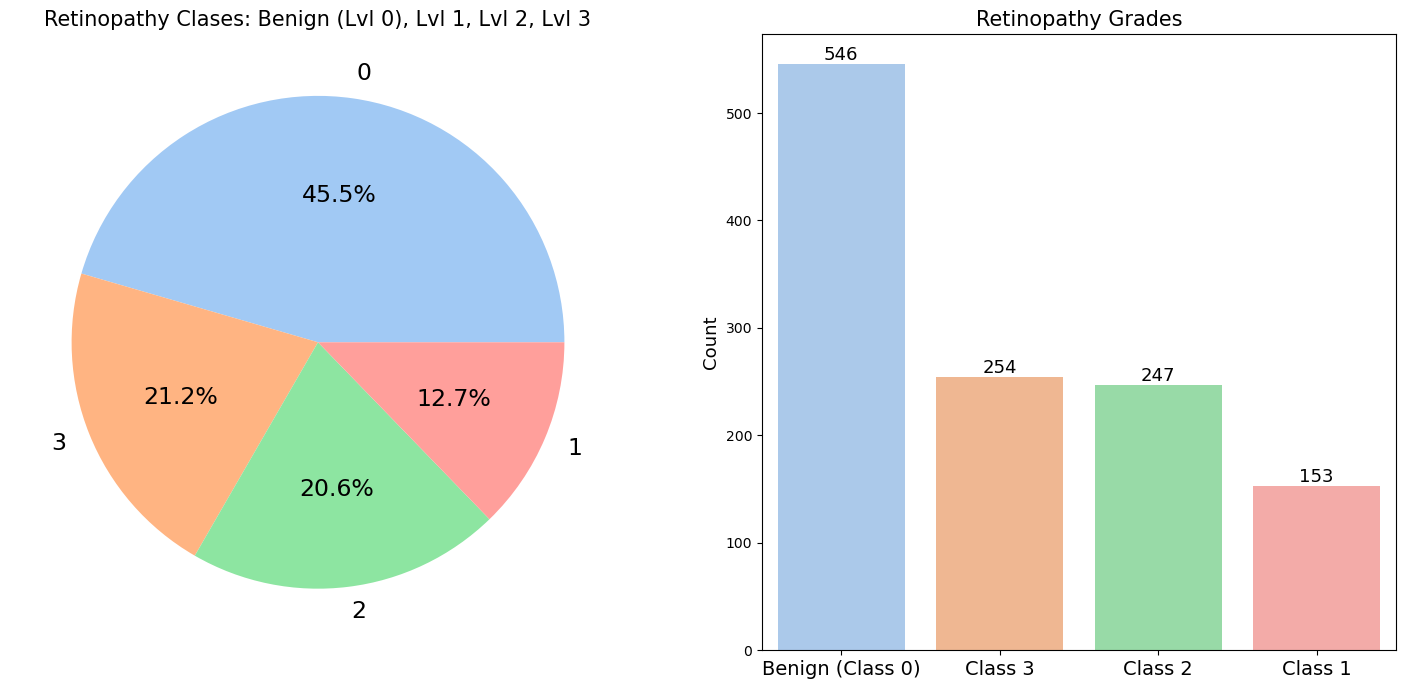

In [6]:
warnings.simplefilter(action='ignore', category=FutureWarning)
#Checking class balance (0: Benign, 1, 2, 3) for main label
fig, ax = plt.subplots(1,2, figsize=(18,8))
retina_data['label'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], fontsize=17, 
                                             colors=sns.color_palette('pastel')[0:5])
ax[0].set_title('Retinopathy Clases: Benign (Lvl 0), Lvl 1, Lvl 2, Lvl 3', fontsize=15)
ax[0].set_ylabel('')
#Countplot for label
sns.countplot('label', data=retina_data, ax=ax[1], order=retina_data['label'].value_counts().index, 
              palette=sns.color_palette('pastel')[0:5]) # palette='coolwarm'
ax[1].bar_label(ax[1].containers[0], fontsize=13)
ax[1].set_title('Retinopathy Grades', fontsize=15)
ax[1].set_ylabel('Count', fontsize=13)
ax[1].set_xlabel('', fontsize=15)
ax[1].set_xticklabels(['Benign (Class 0)', 'Class 3', 'Class 2', 'Class 1'], fontsize=14)
plt.show()

Now that we have our image databse created, let's explore the properties of the images and the types of operations and processing we can do on them

In [7]:
# list file and directories
file_names = os.listdir(dir_path+'\data_processed\data_original')
display(len(file_names)) # checking how many images we have in out data_original database

1200

Since we want to have a similar number of classes, we will be doing some data augmentation on this stage by just simply fliping some images taken from class 1 mainly but also from classes 2 and 3 until we get 260 images of each. These images will be then saved to the data_original database for our further input to the model.

Let's start wirt **Class 1** augmentation

In [8]:
images_class1 = retina_data[retina_data['label'] == 1] # subsetting dataset to take some files
images_class1.head()

In [9]:
images_class1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 2 to 1181
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Image name              153 non-null    object
 1   Zip File                153 non-null    object
 2   Image Size              153 non-null    object
 3   label                   153 non-null    int64 
 4   Risk of macular edema   153 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 7.2+ KB


To distribute as evenly as possible this sampling, we will take 9 Class 1 images from each zip file (12 in total), in this way:

* 9 x 12 = 108 -> augmented Class 1 images
* 153 + 108 = **261** -> Class 1 images in total

But wait... does each zip file has at least 9 images of Class 1? Let's explore it

In [10]:
# list of zip files
zip_names = os.listdir(dir_path+'\data')
display(zip_names)

['Base11.zip',
 'Base12.zip',
 'Base13.zip',
 'Base14.zip',
 'Base21.zip',
 'Base22.zip',
 'Base23.zip',
 'Base24.zip',
 'Base31.zip',
 'Base32.zip',
 'Base33.zip',
 'Base34.zip']

In [11]:
# checking how many of class 1 images each zip file has
for zip_file in zip_names:
    print(zip_file, ':', len(list(retina_data[retina_data['label'] == 1][retina_data[retina_data['label'] == 1]['Zip File'] == zip_file]['Image name'])))

Base11.zip : 13
Base12.zip : 4
Base13.zip : 6
Base14.zip : 7
Base21.zip : 6
Base22.zip : 14
Base23.zip : 20
Base24.zip : 31
Base31.zip : 17
Base32.zip : 0
Base33.zip : 27
Base34.zip : 8


No! In fact, there are some files like Base32.zip that have no Class 1 images at all. Given this information, let's load all names of files in images_class1 dataframe and randomly pop 44 elements from that list:

In [12]:
images_class1_list = list(images_class1['Image name'])
flag = 1

while flag < 45:
    try:
        images_class1_list.pop(np.random.randint(0, len(images_class1_list)+1))
        flag += 1
    except:
        pass

In [13]:
len(images_class1_list)

109

So, our new Class 1 images augmentation is:

* 153 + 109 = **262** -> Class 1 images in total

Now that we have a list of 109 Class 1 images, we will perform three types of transformations in them (randomly chosen) and then save the images into our image database and finally add the image name, label and properties to our labels_sizes.csv file for later use. These are the transformations:

* Flip Vertically
* Flip Horizontally
* Gaussian Image Filter

Let's do that here:

In [14]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# transforming images and adding them to the databse
for file in images_class1_list:
    
    x = np.random.randint(1, 4) # random number to choose type of processing
    
    img_nparray = plt.imread(dir_path+'\data_processed\data_original\{}'.format(file)) # reading one file at a time
    
    if x == 1: # flip vertically
        img_fliplr = np.fliplr(img_nparray)
        imsave('{}\data_processed\data_original\A_{}'.format(dir_path, file), img_fliplr) # Saving images to path
    elif x == 2: # flip horizontally
        img_flipud = np.flipud(img_nparray)
        imsave('{}\data_processed\data_original\A_{}'.format(dir_path, file), img_flipud) # Saving images to path
    else: # gaussian transformation
        if np.random.randint(1, 10) > 5:
            gaussian_image = gaussian(img_nparray, channel_axis=True)
            gaussian_image = np.fliplr(gaussian_image) # fliping images randomly
            gaussian_image = img_as_ubyte(gaussian_image) # converting it back to binary
            imsave('{}\data_processed\data_original\A_{}'.format(dir_path, file), gaussian_image) # Saving images to path
        else:
            gaussian_image = gaussian(img_nparray, channel_axis=True)
            gaussian_image = img_as_ubyte(gaussian_image) # converting it back to binary
            imsave('{}\data_processed\data_original\A_{}'.format(dir_path, file), gaussian_image) # Saving images to path
    
    # saving generated observation in our retina_data data frame
    image_name_a = 'A_{}'.format(file)
    name_zip_a = retina_data.loc[retina_data['Image name']==file, 'Zip File'].values[0]
    image_size_a = retina_data.loc[retina_data['Image name']==file, 'Image Size'].values[0]
    label_a = retina_data.loc[retina_data['Image name']==file, 'label'].values[0]
    rme_a = retina_data.loc[retina_data['Image name']==file, 'Risk of macular edema '].values[0]
    
    # appending the row
    retina_data = retina_data.append({'Image name':image_name_a, 'Zip File':name_zip_a, 'Image Size':image_size_a,
                                'label':label_a, 'Risk of macular edema ':rme_a}, ignore_index=True)
    

Now that we have augmented 109 Class 1 images and added the information to the dataframe, let's check its info: 

In [15]:
retina_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Image name              1309 non-null   object
 1   Zip File                1309 non-null   object
 2   Image Size              1309 non-null   object
 3   label                   1309 non-null   int64 
 4   Risk of macular edema   1309 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 51.3+ KB


Great, we see consistency in the data frame since all dtypes are preserved and there is 1309 observations in it. So now let's check the class balance with this new data:

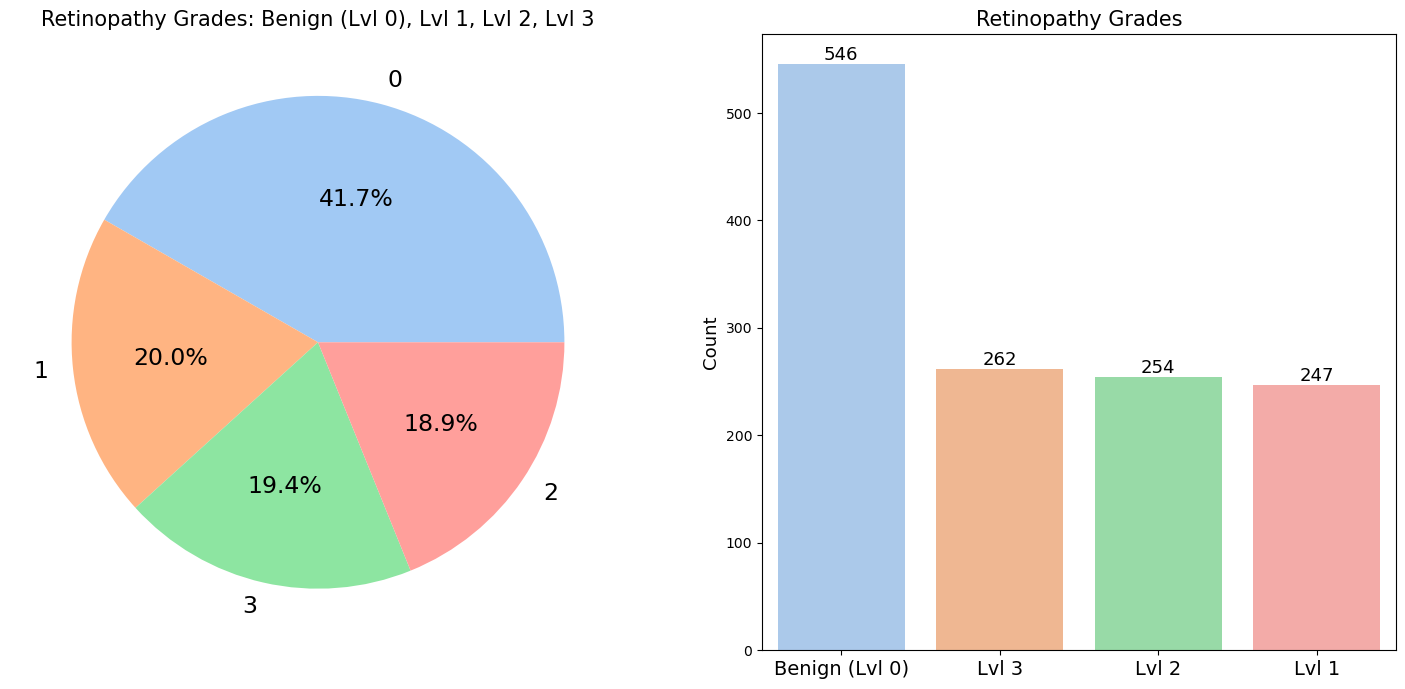

In [19]:
warnings.simplefilter(action='ignore', category=FutureWarning)
#Checking class balance (0: Benign, 1, 2, 3) for main label
fig, ax = plt.subplots(1,2, figsize=(18,8))
retina_data['label'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], fontsize=17, 
                                             colors=sns.color_palette('pastel')[0:5])
ax[0].set_title('Retinopathy Grades: Benign (Lvl 0), Lvl 1, Lvl 2, Lvl 3', fontsize=15)
ax[0].set_ylabel('')
#Countplot for label
sns.countplot('label', data=retina_data, ax=ax[1], order=retina_data['label'].value_counts().index, 
              palette=sns.color_palette('pastel')[0:5]) # palette='coolwarm'
ax[1].bar_label(ax[1].containers[0], fontsize=13)
ax[1].set_title('Retinopathy Grades', fontsize=15)
ax[1].set_ylabel('Count', fontsize=13)
ax[1].set_xlabel('', fontsize=15)
ax[1].set_xticklabels(['Benign (Lvl 0)', 'Lvl 3', 'Lvl 2', 'Lvl 1'], fontsize=14)
plt.show()

Ok, so now our data is better balanced than before (except for class 0, which is much larger than the other three).

The next step in this project is to generate a second database with the images processed in a way that cna be suitable for a deep learning model. But before doing this task, we will explore what type of operations and processing can be done at the images. Let's go for it.

In [ ]:
#########

### PLENTY OF WORK TO BE DONE HERE

########

In [52]:
# taking one sample image to work on
img_nparray = plt.imread(dir_path+'\data_processed\data_original\{}'.format(file_names[8]))

Operations and Processing

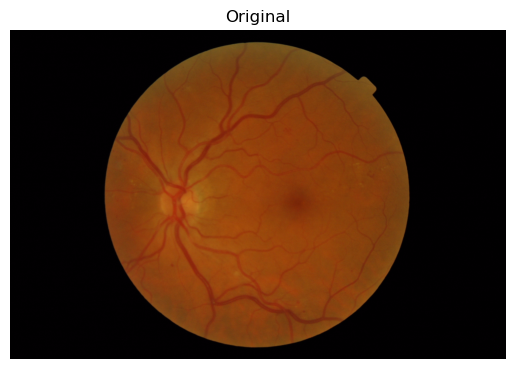

<class 'numpy.ndarray'> (1488, 2240, 3)


In [53]:
h.show_image(img_nparray, title='Original')

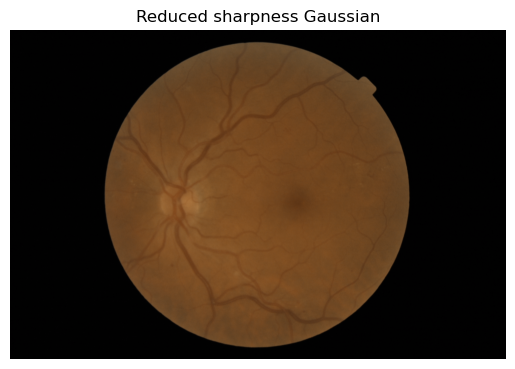

<class 'numpy.ndarray'> (1488, 2240, 3)


In [54]:
gaussian_image = gaussian(img_nparray, channel_axis=True)
h.show_image(gaussian_image, "Reduced sharpness Gaussian")

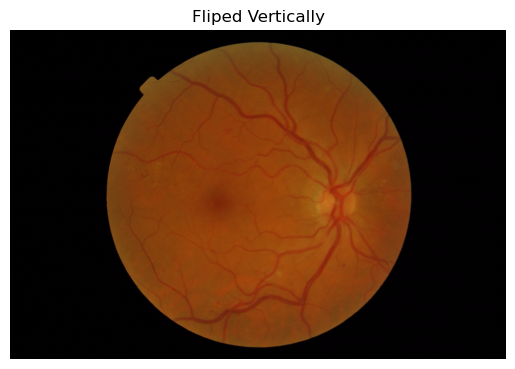

<class 'numpy.ndarray'> (1488, 2240, 3)


In [55]:
img_flipud = np.flipud(img_nparray)
img_fliplr = np.fliplr(img_nparray)
h.show_image(img_fliplr, title='Fliped Vertically') # fliplr to flip horizontally

## Operations

### Convert to Gray Scale

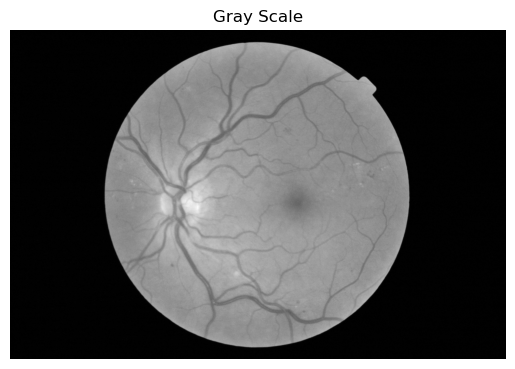

<class 'numpy.ndarray'> (1488, 2240)


In [56]:
img_gray = color.rgb2gray(img_nparray)
h.show_image(img_gray, title='Gray Scale')

### RGB Channels (Histograms)

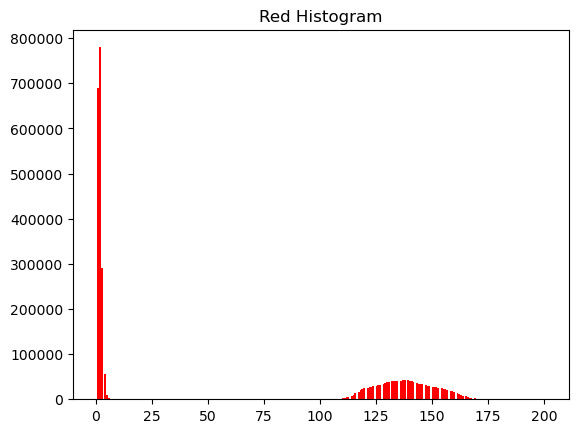

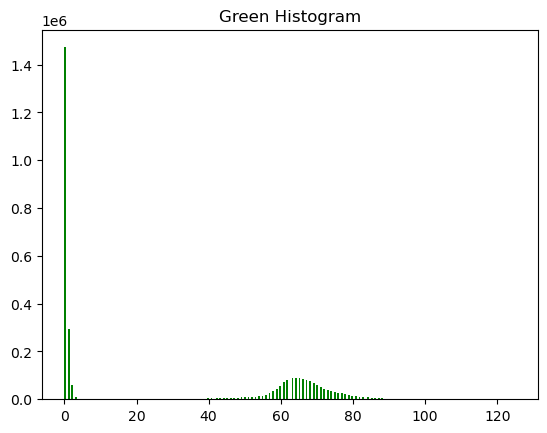

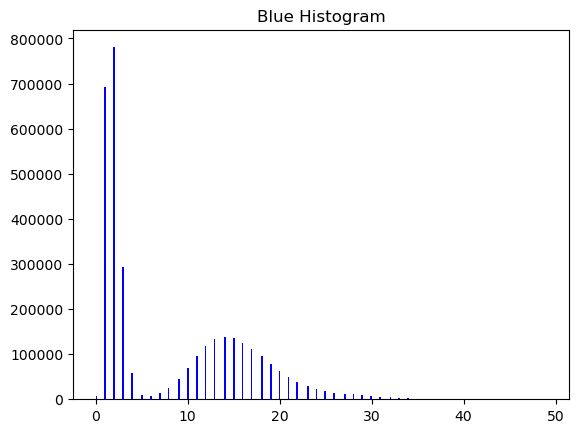

In [57]:
# Getting the RGB channels from the image
red_channel = img_nparray[:, :, 0] # Obtain the red channel
green_channel = img_nparray[:, :, 1] # Obtain the green channel
blue_channel = img_nparray[:, :, 2] # Obtain the blue channel

# Plot the red histogram with bins in a range of 256
plt.hist(red_channel.ravel(), bins=256, color='red')
# Set title and show
plt.title('Red Histogram')
plt.show()

# Plot the green histogram with bins in a range of 256
plt.hist(green_channel.ravel(), bins=256, color='green')
plt.title('Green Histogram')
plt.show()

# Plot the blue histogram with bins in a range of 256
plt.hist(blue_channel.ravel(), bins=256, color='blue')
plt.title('Blue Histogram')
plt.show()

## Thresholding

### Binary Image

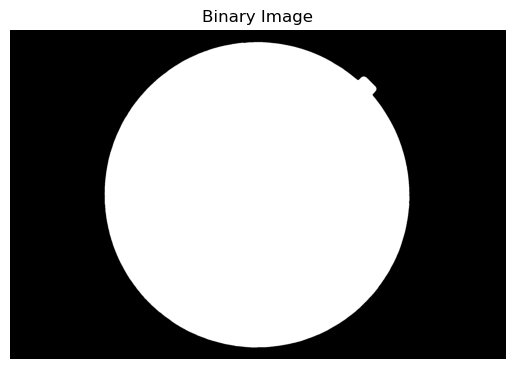

<class 'numpy.ndarray'> (1488, 2240)


In [58]:
# Make the image grayscale using rgb2gray
img_gray = color.rgb2gray(img_nparray)
# Obtain the optimal threshold value with otsu
thresh = threshold_otsu(img_gray)
# Apply thresholding to the image
binary = img_gray > thresh
# Show the image
h.show_image(binary, 'Binary Image')

### Global Thresholding

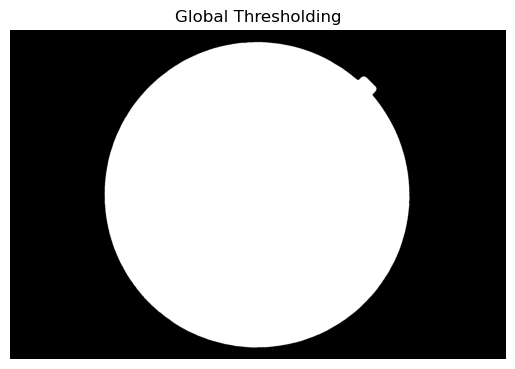

<class 'numpy.ndarray'> (1488, 2240)


In [59]:
# Make the image grayscale using rgb2gray
img_gray = color.rgb2gray(img_nparray)
# Obtain the optimal otsu global thresh value
global_thresh = threshold_otsu(img_gray)
# Obtain the binary image by applying global thresholding
binary_global = img_gray > global_thresh
# Show the binary image obtained
h.show_image(binary_global, 'Global Thresholding')

### Local Thresholding

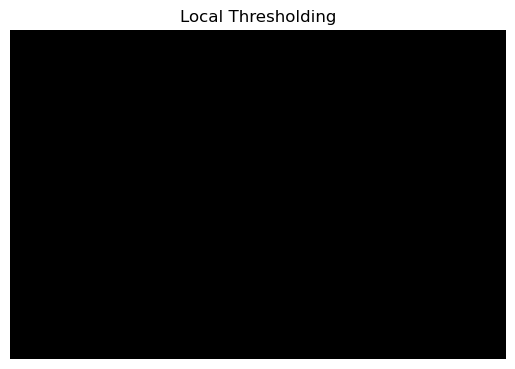

<class 'numpy.ndarray'> (1488, 2240)


In [60]:
# Make the image grayscale using rgb2gray
img_gray = color.rgb2gray(img_nparray)
# Set the block size to 35
block_size = 35
# Obtain the optimal local thresholding
local_thresh = threshold_local(img_gray, block_size, offset=10)
# Obtain the binary image by applying local thresholding
binary_local = img_gray > local_thresh
# Show the binary image
h.show_image(binary_local, 'Local Thresholding')

### Trying All Thresholds

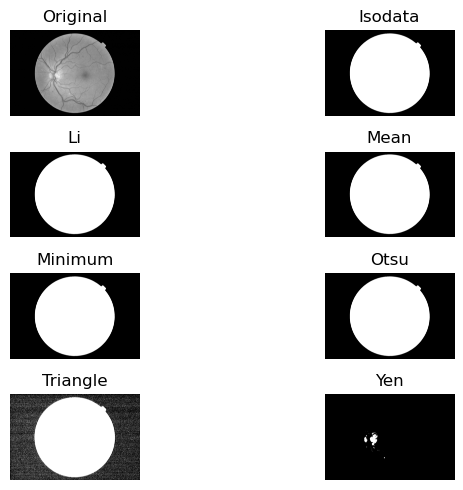

In [61]:
# Make the image grayscale using rgb2gray
img_gray = color.rgb2gray(img_nparray)
# Use the try all method on the resulting grayscale image
fig, ax = try_all_threshold(img_gray, verbose=False)
# Show the resulting plots
plt.show()

## Filtering

### Edge Detection

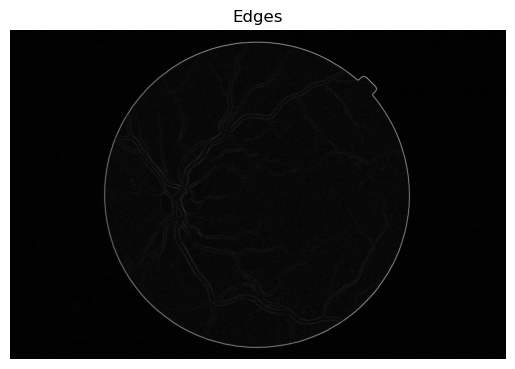

<class 'numpy.ndarray'> (1488, 2240)


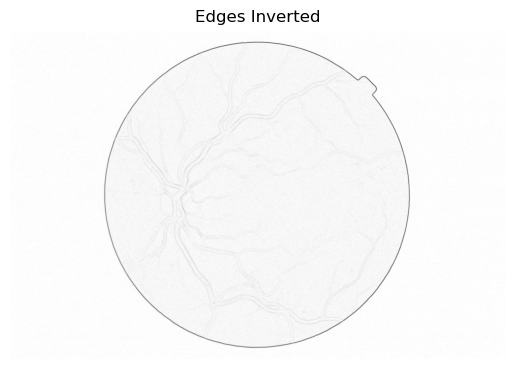

<class 'numpy.ndarray'> (1488, 2240)


In [62]:
# Make the image grayscale using rgb2gray
img_gray = color.rgb2gray(img_nparray)
img_edges = sobel(img_gray)
# Show the edge image
h.show_image(img_edges, 'Edges')
# Show the edge image inverted
h.show_image(img_edges, title='Edges Inverted', cmap_type="gist_yarg")

### Blurring to Reduce Noise

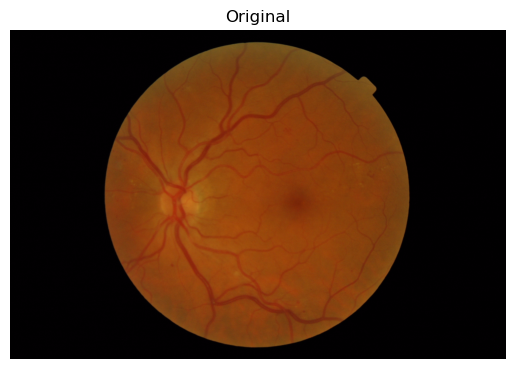

<class 'numpy.ndarray'> (1488, 2240, 3)


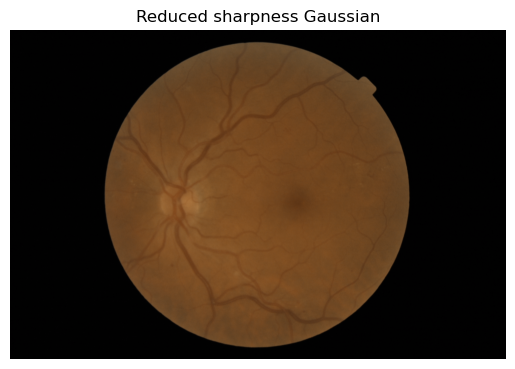

<class 'numpy.ndarray'> (1488, 2240, 3)


In [63]:
gaussian_image = gaussian(img_nparray, channel_axis=True)
h.show_image(img_nparray, "Original")
h.show_image(gaussian_image, "Reduced sharpness Gaussian")

### Contrast Enhancement

Measure of its dynamic range or the spread of its histogram. Contrast enhancement can be done by usinf the **contrast stretching techniques** which is used to stretch the histogram so the full range of intensity values is filled. The other technique used is **histogram equalization** that spreads out the most frequent histogram intensities values using probability distribution. There are three types of histogram equalization:

1. **Standard Histogram Equalization:** Increasing overall contrast
2. **Adaptive Histogram Equalization:** This method computes several histograms, each corresponding to a distinct region of the image, and use them to redistribute the lightest values of the image histogram
3. **Contrast Limited Adaptive HE (CLAHE):** This is similar to 2 but it softeness the noise in the image since it is not taking the global histogram but operates in small regions.

#### Standard Histogram Equalization

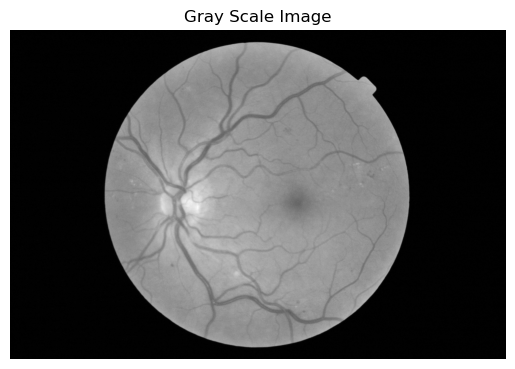

<class 'numpy.ndarray'> (1488, 2240)


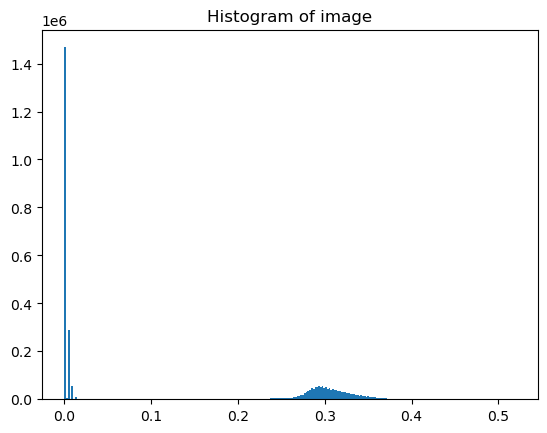

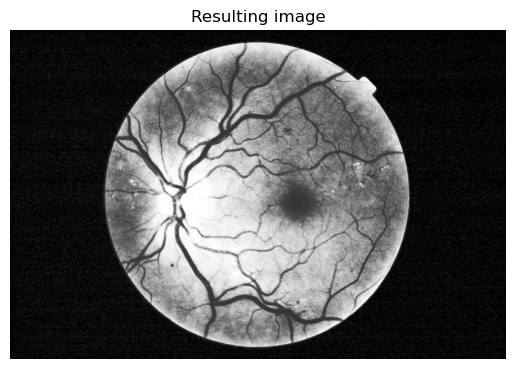

<class 'numpy.ndarray'> (1488, 2240)


In [64]:
# Make the image grayscale using rgb2gray
img_gray = color.rgb2gray(img_nparray)
# Show original x-ray image and its histogram
h.show_image(img_gray, 'Gray Scale Image')

# histogram
plt.title('Histogram of image')
plt.hist(img_gray.ravel(), bins=256)
plt.show()

# Use histogram equalization to improve the contrast
img_hist_eq = exposure.equalize_hist(img_gray)
# Show the resulting image
h.show_image(img_hist_eq, 'Resulting image')

#### CLAHE

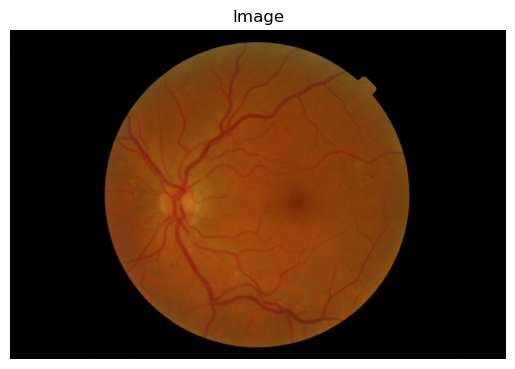

<class 'numpy.ndarray'> (1488, 2240, 3)


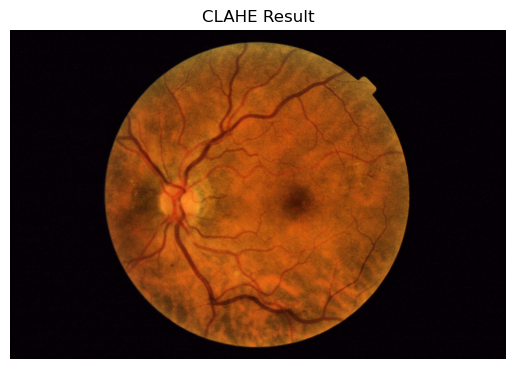

<class 'numpy.ndarray'> (1488, 2240, 3)


In [65]:
# Apply the adaptive equalization on the original image
adapthist_eq_image = exposure.equalize_adapthist(img_nparray, clip_limit=0.02)

# Compare the original image to the equalized
h.show_image(img_nparray)
h.show_image(adapthist_eq_image, 'CLAHE Result')

### Hysteresis Thresholding

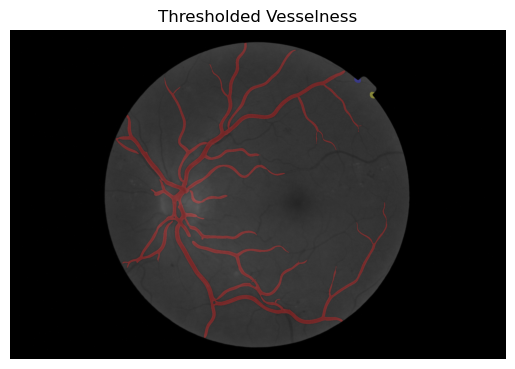

In [66]:
# Hysteresis Thresholding
retina = color.rgb2gray(img_nparray)
t0, t1 = filters.threshold_multiotsu(retina, classes=3)
mask = (retina > t0)
vessels = filters.sato(retina, sigmas=range(1, 10)) * mask

thresholded = filters.apply_hysteresis_threshold(vessels, 0.01, 0.03)
labeled = ndi.label(thresholded)[0]

_, ax = plt.subplots()
ax.imshow(color.label2rgb(labeled, retina))
ax.set_axis_off()
_ = ax.set_title('Thresholded Vesselness')

### Applying the Vesselness Filter

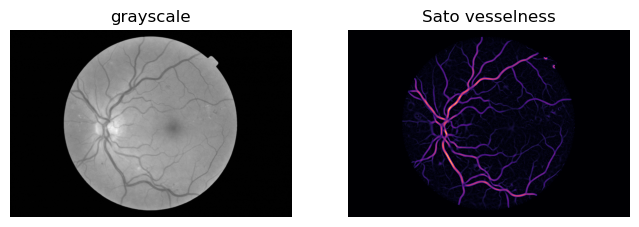

In [67]:
retina = color.rgb2gray(img_nparray)
t0, t1 = filters.threshold_multiotsu(retina, classes=3)
mask = (retina > t0)
vessels = filters.sato(retina, sigmas=range(1, 10)) * mask

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
axes[0].imshow(retina, cmap='gray')
axes[0].set_axis_off()
axes[0].set_title('grayscale')
axes[1].imshow(vessels, cmap='magma')
axes[1].set_axis_off()
_ = axes[1].set_title('Sato vesselness')

### Skelotonize

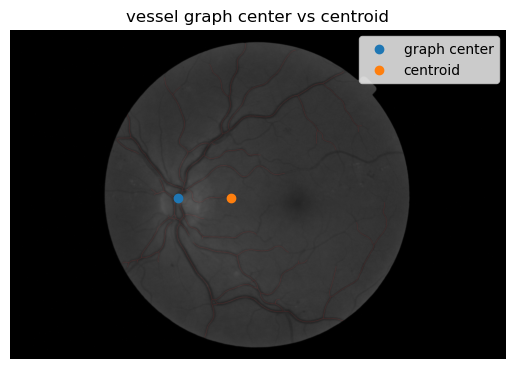

In [68]:
largest_nonzero_label = np.argmax(np.bincount(labeled[labeled > 0]))
binary = labeled == largest_nonzero_label
skeleton = morphology.skeletonize(binary)
g, nodes = graph.pixel_graph(skeleton, connectivity=2)
px, distances = graph.central_pixel(
        g, nodes=nodes, shape=skeleton.shape, partition_size=100
        )

centroid = measure.centroid(labeled > 0)

_, ax = plt.subplots()
ax.imshow(color.label2rgb(skeleton, retina))
ax.scatter(px[1], px[0], label='graph center')
ax.scatter(centroid[1], centroid[0], label='centroid')
ax.legend()
ax.set_axis_off()
ax.set_title('vessel graph center vs centroid')

plt.show()

## Transformations

### Reducing with Antialiasing

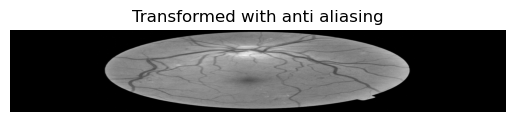

<class 'numpy.ndarray'> (372, 2240, 1)


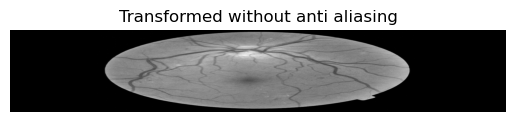

<class 'numpy.ndarray'> (372, 2240, 1)


In [69]:
# Rotate the image 90 degrees clockwise 
rotated_img = rotate(img_nparray, -90)

# Rescale with anti aliasing
rescaled_with_aa = rescale(rotated_img, 1/4, anti_aliasing=True, channel_axis=True)

# Rescale without anti aliasing
rescaled_without_aa = rescaled_with_aa = rescale(rotated_img, 1/4, anti_aliasing=False, channel_axis=True)

# Show the resulting images
h.show_image(rescaled_with_aa, "Transformed with anti aliasing")
h.show_image(rescaled_without_aa, "Transformed without anti aliasing")

### Enlarging Images

In [70]:
# Enlarge the image so it is 3 times bigger
enlarged_img = rescale(img_nparray, 1, anti_aliasing=True, channel_axis=True)

# Show original and resulting image
#show_image(img_nparray)
#show_image(enlarged_img, "3 times enlarged image")

### Proportionally Resizing

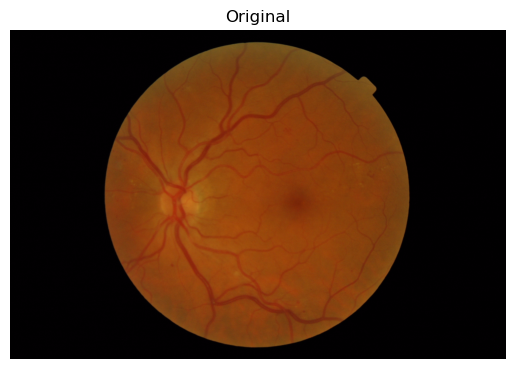

<class 'numpy.ndarray'> (1488, 2240, 3)


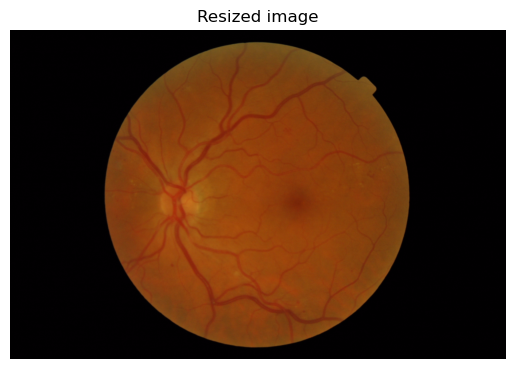

<class 'numpy.ndarray'> (744, 1120, 3)


In [71]:
# Set proportional height so its half its size
height = int(img_nparray.shape[0] / 2)
width = int(img_nparray.shape[1] / 2)

# Resize using the calculated proportional height and width
image_resized = resize(img_nparray, (height, width),
                       anti_aliasing=True)

# Show the original and resized image
h.show_image(img_nparray, 'Original')
h.show_image(image_resized, 'Resized image')

## Morphology

Basic Morphological Operations Include:

1. **Dilation:** Adds pixels to the boundaries of the objects in an image
2. **Erotion:** Removes pixels on object's boundaries

The number of pixels added or removed on an image depends on the size and shape of a structuring element used to process the image (like a kernel).

### Erosion

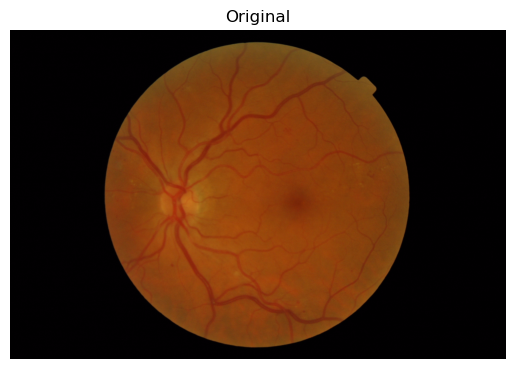

<class 'numpy.ndarray'> (1488, 2240, 3)


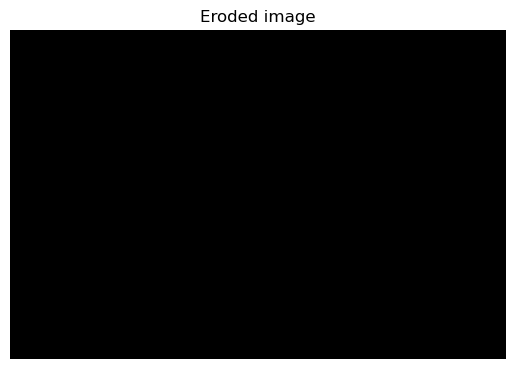

<class 'numpy.ndarray'> (1488, 2240)


In [72]:
# Make the image grayscale using rgb2gray
img_gray = color.rgb2gray(img_nparray)
# Obtain the eroded shape 
eroded_image_shape = morphology.binary_erosion(img_gray) 

# See results
h.show_image(img_nparray, 'Original')
h.show_image(eroded_image_shape, 'Eroded image')

### Dilation

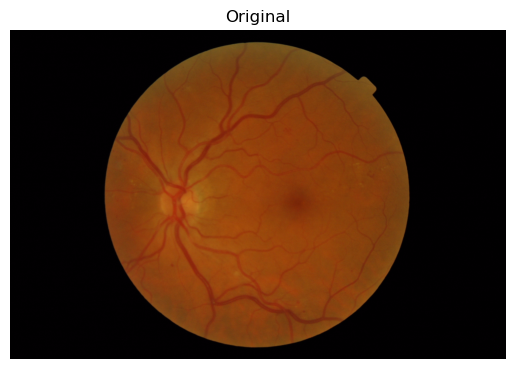

<class 'numpy.ndarray'> (1488, 2240, 3)


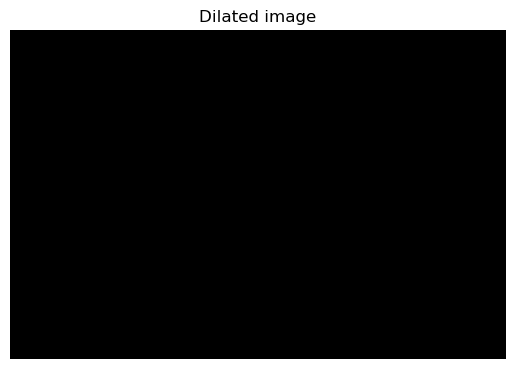

<class 'numpy.ndarray'> (1488, 2240)


In [73]:
# Make the image grayscale using rgb2gray
img_gray = color.rgb2gray(img_nparray)
# Obtain the dilated image 
dilated_image = morphology.binary_dilation(img_gray)

# See results
h.show_image(img_nparray, 'Original')
h.show_image(dilated_image, 'Dilated image')

## Segmentation

The goal is to change the representation into something more meaningful and easier to analyze by increasing computational efficiency, the segmentation is done by using superpixels. Thresholding is the simplest method for segmentation.

**Superpixel:** group of connected pixels with similar color or gray levels

Segmentation can be done in a supervised or unsupervised way. Supervised being when prior information like threshold values is provided before the segmentation. Unsupervised is when there is no information given, for doing unsupervised we can apply a KNN-like model in the image to get some features from the image.

For this project however, segmentation will be only required for computational purposes since it sould harm the resolution of the vessels in the image (objects of interest).

## Contours

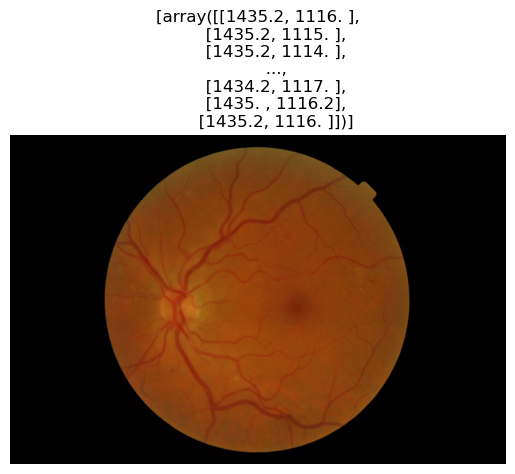

<class 'numpy.ndarray'> (1488, 2240, 3)


In [74]:
# Make the image grayscale using rgb2gray
img_gray = color.rgb2gray(img_nparray)
# Obtain the optimal thresh value
thresh = filters.threshold_otsu(img_gray)
# Apply thresholding
binary = img_gray > thresh
# Find contours at a constant value of 0.8
contours = measure.find_contours(binary, 0.8)
# Show the image
h.show_image(img_nparray, contours)

## Detecting Edges

The Canny edge detection is the standar edge detection technique in image processing that produces high accuracy in detection edges and less execution time. The goal is to detecte edges in the image and highlight them with thicker lines for spotting them more accurately. 

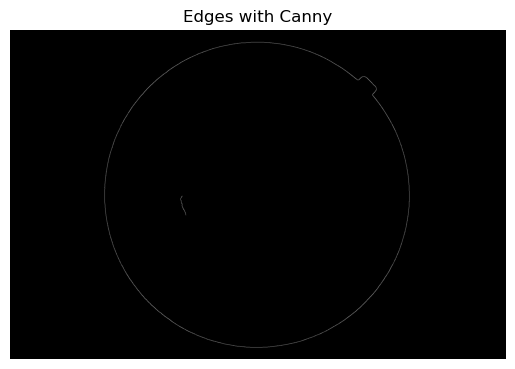

<class 'numpy.ndarray'> (1488, 2240)


In [75]:
# Convert image to grayscale
img_gray = color.rgb2gray(img_nparray)
# Apply canny edge detector
canny_edges = canny(img_gray)
# Show resulting image
h.show_image(canny_edges, "Edges with Canny")

### Less or More Edgy

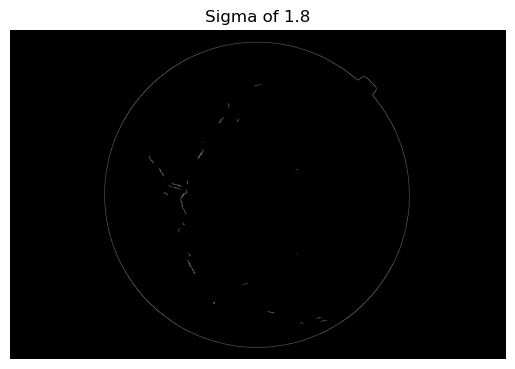

<class 'numpy.ndarray'> (1488, 2240)


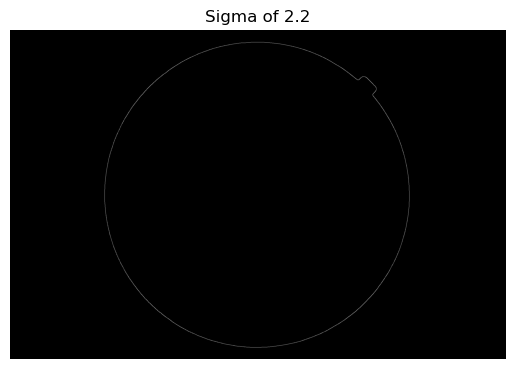

<class 'numpy.ndarray'> (1488, 2240)


In [76]:
# Apply canny edge detector with a sigma of 1.8
edges_1_8 = canny(img_gray, sigma=0.002)
# Apply canny edge detector with a sigma of 2.2
edges_2_2 = canny(img_gray, sigma=2.2)
# Show resulting images
h.show_image(edges_1_8, "Sigma of 1.8")
h.show_image(edges_2_2, "Sigma of 2.2")

### Summary of Operations / Transformations / Morphology

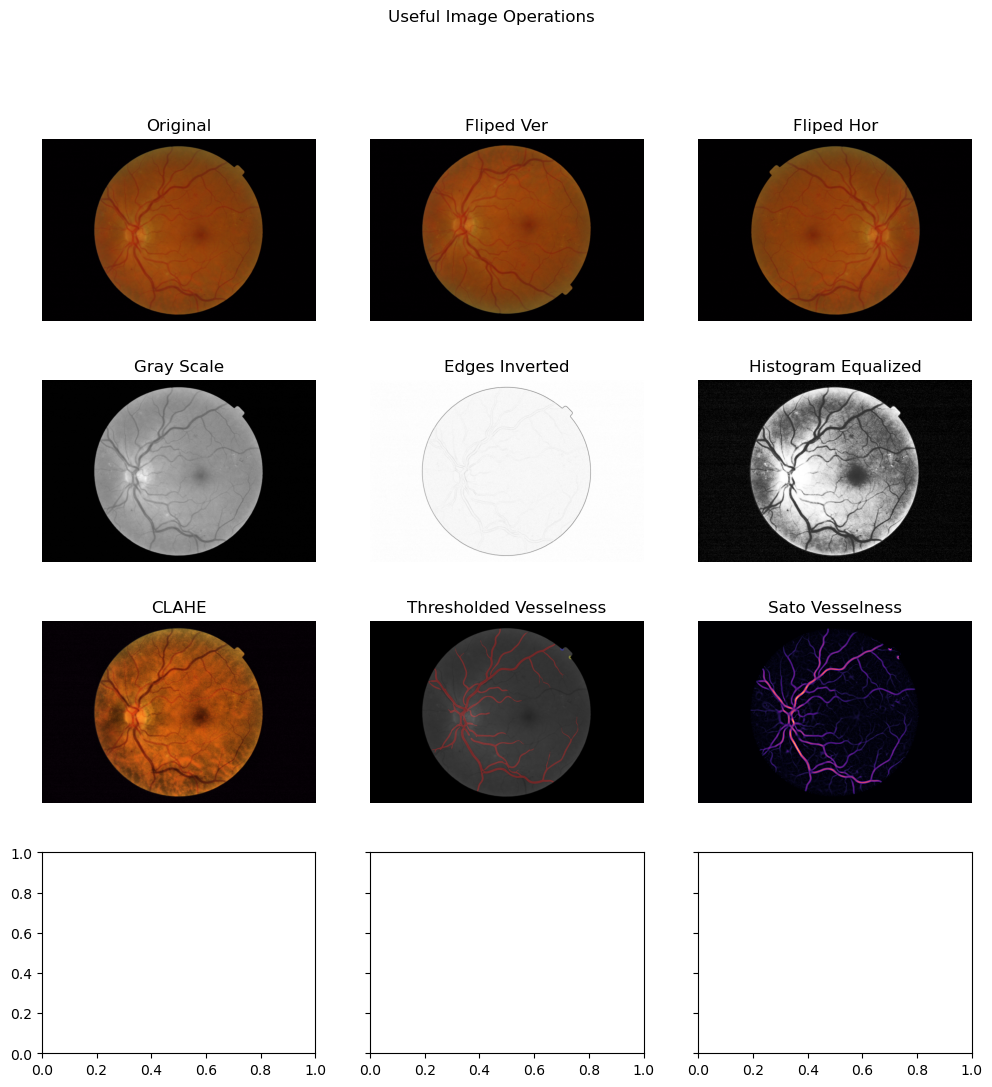

In [77]:
# setting different parameters to adjust each grid
fig, axs = plt.subplots(4, 3, figsize=(12,12))
#fig.tight_layout()
fig.suptitle('Useful Image Operations')

axs[0,0].imshow(img_nparray, cmap='gray')
axs[0,0].set_axis_off()
axs[0,0].set_title('Original')

axs[0,1].imshow(img_flipud, cmap='gray')
axs[0,1].set_axis_off()
axs[0,1].set_title('Fliped Ver')

axs[0,2].imshow(img_fliplr, cmap='gray')
axs[0,2].set_axis_off()
axs[0,2].set_title('Fliped Hor')

axs[1,0].imshow(img_gray, cmap='gray')
axs[1,0].set_axis_off()
axs[1,0].set_title('Gray Scale')

axs[1,1].imshow(img_edges, cmap="gist_yarg")
axs[1,1].set_axis_off()
axs[1,1].set_title('Edges Inverted')

axs[1,2].imshow(img_hist_eq, cmap='gray')
axs[1,2].set_axis_off()
axs[1,2].set_title('Histogram Equalized')

axs[2,0].imshow(adapthist_eq_image)
axs[2,0].set_axis_off()
axs[2,0].set_title('CLAHE')

axs[2,1].imshow(color.label2rgb(labeled, retina))
axs[2,1].set_axis_off()
axs[2,1].set_title('Thresholded Vesselness')

axs[2,2].imshow(vessels, cmap='magma')
axs[2,2].set_axis_off()
axs[2,2].set_title('Sato Vesselness')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()